## Generating synthetic data as the Javelin github uses.
Very much trying to replicate https://github.com/nye17/javelin. In the Zu et al. 2011 paper they say they are using a DRW from Kelly et al. 2009. Did that above, using their equation (1), modified so I got similar results as they did:
$\begin{equation}
    dX(t) = X(t)\exp{\left[{-\frac{1}{\tau}dt}\right]} + \sigma\sqrt{dt}\:\epsilon(t) + b\: \left(1-\exp{\left[{-\frac{1}{\tau}dt}\right]}\right)
\end{equation}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set_theme()
from scipy.signal import convolve

In [2]:
# defining the step dX(t):
def gen_drw(t, tau, sigma, b, x0=0.):
    """Damped Random Walk Step
    Args:
        t (array): the time series
        tau (float): relaxation time / characteristic time scale, origin in characteristic timescales for quasars
        sigma (float): variance
        b (float): mean? unsure atm
        x0 (float): starting value
    
    Returns:
        x (array): Damped Random Walk
    """
    
    x = np.zeros_like(t)
    x[0] = x0
    dt = np.diff(t)
    for i in range(1, len(t)):
        exp_term = np.exp(- dt[i-1] / tau)
        x[i] = x[i-1] * exp_term + sigma * np.sqrt(dt[i-1]) * np.random.normal(0, 1) + b * (1 - exp_term)
    
    return x

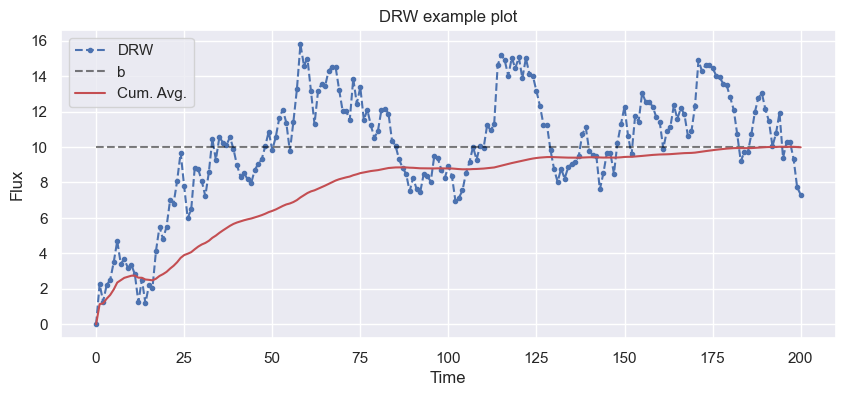

In [3]:
t = np.linspace(0, 200, 201)
tau, sigma, b = 10, 1, 10
params = [tau, sigma, b]
flux = gen_drw(t, *params)

# plot
plt.figure(figsize=(10, 4))
plt.plot(t, flux, '.--', label=('DRW'))
plt.hlines(b, t[0], t[-1], colors='black', linestyles="dashed", alpha=0.5, label='b')
# cumulative average?
cumavg = np.cumsum(flux)/np.linspace(1, len(flux), len(flux))
plt.plot(t, cumavg, 'r', label='Cum. Avg.')
plt.xlabel('Time'), plt.ylabel('Flux'), plt.title('DRW example plot')
plt.legend(), plt.show() ;

So that's our continuum. Now, to generate lagged line spectra. These needs three parameters: the lag t, the width of the tophat smoothing function w, and the flux scaling factor s.

In [4]:
def gen_lag(c_t, c_f, t, w, s):
    """Takes the time and flux arrays from a continuum and lags, smoothes, and scales them
    Args:
        c_t (array): continuum time array
        c_f (array): continuum flux array
        t (float): lag time
        w (float): smoothing width
        s (float): scale factor

    Returns:
        lag_t: lagged time
        lag_f: smoothed and scaled flux
    """
    
    lag_t = c_t + t
    tophat = np.ones(int(w))/w # tophat kernel for smoothing. convolve with signal to smooth
    lag_f = s*(convolve(c_f, tophat, mode='same'))
    return lag_t, lag_f

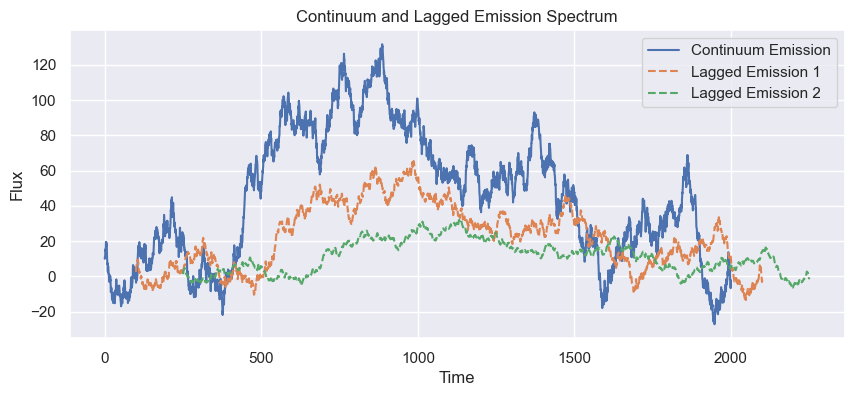

In [5]:
np.random.seed(42)  # For reproducibility
continuum_times = np.linspace(0, 2000, 4001)  # arbitrary n
continuum_flux = gen_drw(continuum_times, 400., 3., 10., 10.)  # using javelin's numbers

# Generate a lagged spectrum
p1 = 100, 2, 0.5 # Ylem numbers from javelin
p2 = 250, 4, 0.25 # Zing numbers from javelin
params = [p1, p2]
# max_lag = params[-1][0] # assuming they are made in sequential order, more and more lagged, this should be the highest lag in the code. if not, stop being stupid.

plt.figure(figsize=(10, 4))
plt.plot(continuum_times, continuum_flux, label='Continuum Emission')
for i, p in enumerate(params):
    lag, width, scale = p
    lagged_times, lagged_flux = gen_lag(continuum_times, continuum_flux, lag, width, scale)
    plt.plot(lagged_times, lagged_flux, label=f'Lagged Emission {i+1}', linestyle='--')
plt.xlabel('Time'), plt.ylabel('Flux'), plt.legend(), plt.title('Continuum and Lagged Emission Spectrum')
plt.show()

Obviously there is the problem of the data no longer "starting" at the same time. In reality, the continuum would be continuous in time and therefore the lagged signals would contain flux that originates earlier than the earliest point we can see in the continuum. Assuming they start simultaneously. Idk how javelin gets around this other than just cutting the arrays to look nice. It's not automated.

Smoothing is a little arcane to me and might not be exactly how they've done it in javelin.

Next is masking out seasonal gaps, adding noise and downsampling.

In [6]:
def downsample(times, flux, noise=1., downsample_rate=0.3, gap_gap=180, gap_length=90):    
    """This function modifies the simulated 'true' signal to resemble one that might better represent real-world data, observed with an instrument.
    It downsamples the input time and flux arrays, adds seasonal gaps in the observations, and adds noise to the flux

    Args:
        times (array): Input time array
        flux (array): Input flux array
        noise (float, optional): Magnitude of the noise (normal distr.). Defaults to 1.0.
        downsample_rate (float, optional): fraction of points to keep (0<x<=1). Defaults to 0.3.
        gap_gap (int, optional): Length between seasonal gaps. Defaults to 180.
        gap_length (int, optional): Length of a seaonal gap. If larger than gap_gap, no points will remain. Defaults to 90.
        lag (int, optional): Lag of the input times and flux compared to the continuum. Unused. Defaults to 0.
        max_lag (_type_, optional): The max lag of any dataset generated. Defaults to max_lag.

    Returns:
        gap_times (array): downsampled time array
        gap_flux (array): downsampled flux array
    """
    
    # downsample
    num = len(times)
    keep_indices = np.random.choice(num, int(downsample_rate * num), replace=False)
    keep_indices.sort()
    downsampled_times = times[keep_indices]
    downsampled_flux = flux[keep_indices]
    
    # apply seasonal mask
    mask = np.ones_like(downsampled_times, dtype=bool)
    for i in np.arange(downsampled_times[0], downsampled_times[-1], gap_gap):
        start = i
        length = i + gap_length
        mask &= (downsampled_times < start) | (downsampled_times >= length) # &= means "AND" bc mask is already all trues. now both mask and the conditions have to be true
                                                                            # the conditions are "times before the start time" *or* "times after the start+duration time"
        mask = np.roll(mask, -gap_length)    # rolls the mask so they start at 0. We don't often start observing in a seasonal gap.
                                                    # also rolls it so it starts when the last lagged signal starts because we should be cutting the signals to start then.
        
    gap_times = downsampled_times[mask]
    gap_flux = downsampled_flux[mask]
    
    # add noise to flux
    gap_flux += np.random.normal(0, noise, size=len(gap_flux))
    
    return gap_times, gap_flux

In [7]:
# generate new continuum and lagged line(s)
np.random.seed(42)  # For reproducibility
continuum_times = np.linspace(0, 2000, 4001)  # arbitrary n
continuum_flux = gen_drw(continuum_times, 400., 3., 10., 10.)

class line:
    def __init__(self, lag, smoothing, scale, time=[], flux=[]):
        self.lag = lag
        self.smoothing = smoothing
        self.scale = scale
        self.time = time
        self.flux = flux

Ylem = line(100, 2, 0.5)
Zing = line(250, 4, 0.25)

In [8]:
for dicts in [Ylem, Zing]:
    dicts.time, dicts.flux = gen_lag(continuum_times, continuum_flux, dicts.lag, dicts.smoothing, dicts.scale)
# Ylem.time, Ylem.flux = gen_lag(continuum_times, continuum_flux, Ylem.lag, Ylem.smoothing, Ylem.scale)
# Zing.time, Zing.flux = gen_lag(continuum_times, continuum_flux, Zing.lag, Zing.smoothing, Zing.scale)

# cut to size
lags = [Ylem.lag, Zing.lag]
max_lag = max(lags)

def unify_length(c, y, z, lags):
    max_lag = max(Ylem.lag, Zing.lag)
    
    c = c[0][max_lag:]


In [9]:
sim_c_times, sim_c_flux = downsample(continuum_times, continuum_flux)
sim_ylem_times, sim_ylem_flux = downsample(Ylem.time, Ylem.flux)
sim_zing_times, sim_zing_flux = downsample(Zing.time, Zing.flux)

Sidenote: At this point I am confident that using dictionaries, or even classes, would make this more convenient to deal with, but rewriting this is not on the docket rn.

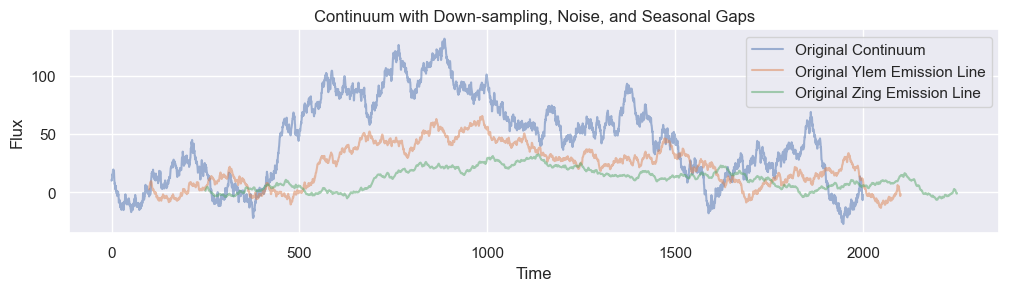

In [10]:
plt.figure(figsize=(12, 9))
ax = plt.subplot(3, 1, 1)
plt.plot(continuum_times, continuum_flux, label='Original Continuum', alpha=0.5)
plt.plot(Ylem.time, Ylem.flux, label='Original Ylem Emission Line', alpha=0.5)
plt.plot(Zing.time, Zing.flux, label='Original Zing Emission Line', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Flux')
# plt.xlim(0, 1000)
plt.title('Continuum with Down-sampling, Noise, and Seasonal Gaps')
plt.legend()

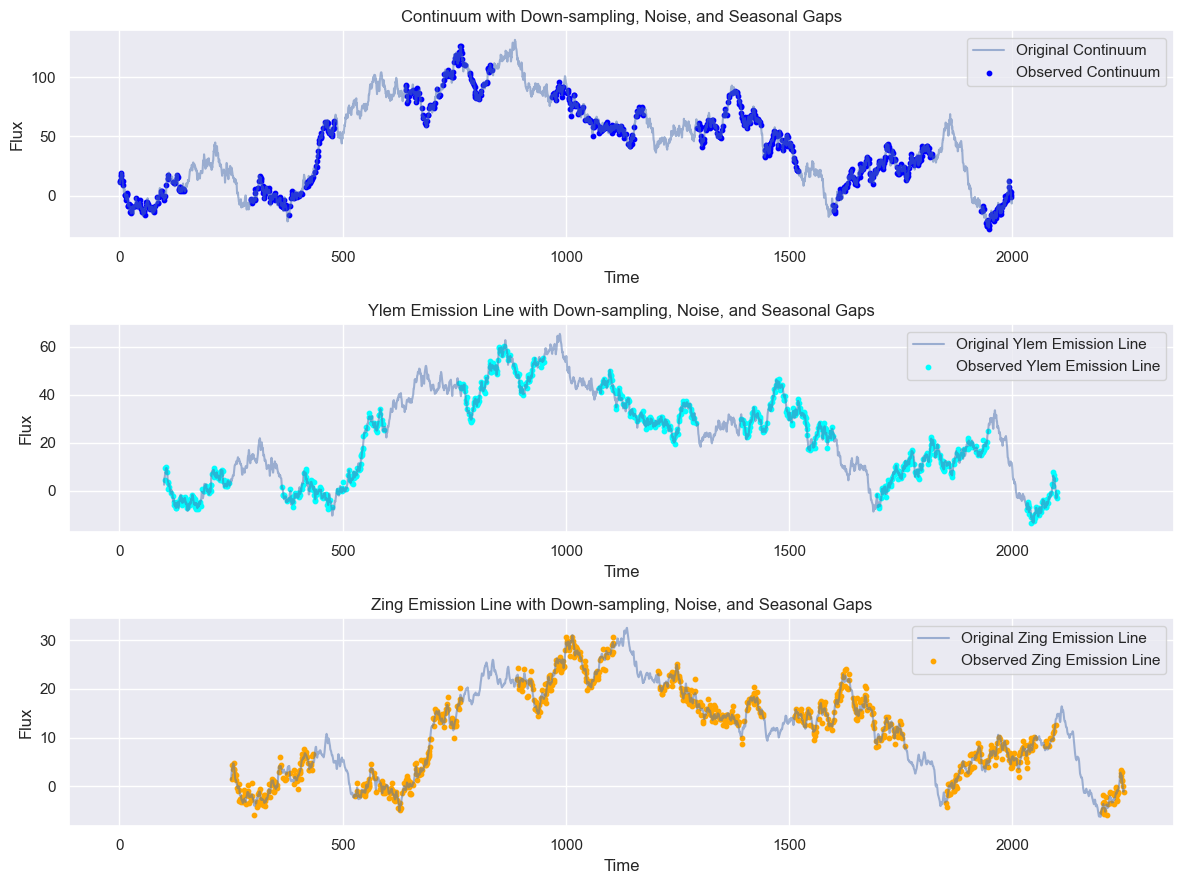

In [11]:
plt.figure(figsize=(12, 9))
ax = plt.subplot(3, 1, 1)
plt.plot(continuum_times, continuum_flux, label='Original Continuum', alpha=0.5)
plt.scatter(sim_c_times, sim_c_flux, color='blue', label='Observed Continuum', s=10)
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Continuum with Down-sampling, Noise, and Seasonal Gaps')
plt.legend()

plt.subplot(3, 1, 2, sharex=ax)
plt.plot(Ylem.time, Ylem.flux, label='Original Ylem Emission Line', alpha=0.5)
plt.scatter(sim_ylem_times, sim_ylem_flux, color='cyan', label='Observed Ylem Emission Line', s=10)
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Ylem Emission Line with Down-sampling, Noise, and Seasonal Gaps')
plt.legend()

plt.subplot(3, 1, 3, sharex=ax)
plt.plot(Zing.time, Zing.flux, label='Original Zing Emission Line', alpha=0.5)
plt.scatter(sim_zing_times, sim_zing_flux, color='orange', label='Observed Zing Emission Line', s=10)
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Zing Emission Line with Down-sampling, Noise, and Seasonal Gaps')
plt.legend()

plt.tight_layout()
plt.show()

The seasonal gaps need to line up, which they don't, and should probably also roll so that they start at 0, not at gap_length. i'm really tired.